# Plot Kinematical distribution of tagged and untagged events 
$x_B, Q^2, W, z_{\pi}...$

If possible, apply background subtraction of tagged events, based on ToF

last edit July-14, 2022

## Imports and definitions

In [2]:
import sys; 
software_path = '/Users/erezcohen/Desktop/Software/'
sys.path.insert(0, software_path + '/mySoftware/Python/');
sys.path.insert(0, software_path + '/CLAS12/BAND/SIDIS_at_BAND/PythonAnalysis/AcceptanceCorrections/');
sys.path.insert(0, software_path + '/CLAS12/BAND/SIDIS_at_BAND/PythonAnalysis/python_auxiliary/');
from my_tools                     import *; 
from plot_tools                   import *;
from my_data_analysis_tools       import *;
from acceptance_correction_tools  import *;
from sidis_analysis_tools         import *;
# from event_selection_tools        import *;

In [3]:
%config InlineBackend.figure_format = 'retina'
plt.rcParams['mathtext.fontset']    = 'stix'
plt.rcParams['font.family']         = 'STIXGeneral'

# (1) Load data:
selected runs of $(e,e'\pi)$ data

In [4]:
load_SIDIS_data( Nruns = 1, do_e_e_pi=True, fdebug=1)

Done loading files.

Total statistics:
632087  (e,e'π+) events
28  (e,e'π+n) events
272140  (e,e'π-) events
10  (e,e'π-n) events


and all runs of $(e,e'\pi n)$

In [32]:
load_SIDIS_data( Nruns = 2, do_e_e_pi=False, fdebug=1)

Done loading files.

Total statistics:
70  (e,e'π+n) events
24  (e,e'π-n) events


# (2) Apply selection cuts not previously imposed
without the cut on $p_n > 0.275$ GeV/c

In [33]:
e_e_pi_pass_cuts,e_e_pi_n_pass_cuts,_ = apply_further_selection_cuts_to_data(doApply_minPn_cut=False, 
                                                                             fdebug=2, 
                                                                             NeventsMax=-1);

Applying selection cuts not previously imposed
(1) DATA
(e,e'π)
Apply a π+/π- acceptance matching cut on the in p-theta plane
Applying p-theta on cut for piplus on 632087 events
Subdividing into 1 subsets up to 500000 events
subset 0 of index 0-499999
Applying p-theta on cut for piminus on 272140 events
Subdividing into 1 subsets up to 500000 events
subset 0 of index 0-272139
Apply a cut on the missing mass of a (e,e'π) reaction: 2.5<Mx<5.0 GeV/c2
(e,e π+ )
632087 events before cut
344801 events after p-theta cut (54.5 %)
311372 events after M_X cut (49.3 %)
169192 events after further Kinematical cut (26.8 %)
(e,e π- )
272140 events before cut
263620 events after p-theta cut (96.9 %)
243676 events after M_X cut (89.5 %)
130300 events after further Kinematical cut (47.9 %)
 
(e,e'πn)
Apply a π+/π- acceptance matching cut on the in p-theta plane
Applying p-theta on cut for piplus on 69 events
Subdividing into 1 subsets up to 500000 events
subset 0 of index 0-68
Applying p-theta on cut f

# (3) Plot kinematical distributions
$ x_B = Q^2/2m_p\omega$

In [ ]:
def plot_SIDIS_variable(var  = 'Q2',
                        bins = np.linspace(1.8,7.8,31),
                        varlabel = '$Q^2$',
                        varunits = '[(GeV/c)$^2$]',
                        xticks = None, 
                        fdebug=1):#{
    
    if fdebug>2: print(bins)
    fig = plt.figure(figsize=(16,10),tight_layout=True)
    h,NeventsTot = dict(),dict()
    # compare untagged to tagged seperately for π+ and π-
    for pi_ch,pi_print,pi_label,pi_color,pi_idx in zip(pi_charge_names,pi_prints,pi_labels,pi_colors,[1,2]):
        ax = fig.add_subplot(2,2,pi_idx)

        df = e_e_pi_pass_cuts[pi_ch]
        NeventsTot['untagged'] = len(df)
        x,h['untagged'+pi_ch],x_err,h_err['untagged'+pi_ch] = plot_step_squares( df[var], ax=ax,bins=bins, 
                                                                                density=True, color='k', alpha=0.5, label='Untagged' )
        ax.step(x,h['untagged'+pi_ch],'-k',where='mid')

        df = e_e_pi_n_pass_cuts[pi_ch]
        NeventsTot['tagged'] = len(df)
        x,h['tagged'+pi_ch],x_err,h_err['tagged'+pi_ch] = plot_step_hist( df[var], bins=bins, 
                                                                         marker='s', markersize=1, color=pi_color,label='Tagged', 
                                                                         alpha=1, density=True)

        set_axes(ax,varlabel+varunits,
                 'Frequency [a.u.]' if pi_idx==1 else '', 
                 title="$(e,e'"+pi_label+")$ events as a function of "+varlabel,
                 do_add_grid=True, do_add_legend=True,xticks=xticks)
        
        
    # compare tagged π+ to π-
    ax = fig.add_subplot(2,2,3)
    for pi_ch,pi_print,pi_label,pi_color,pi_idx in zip(pi_charge_names,pi_prints,pi_labels,pi_colors,[1,2]):
        df = e_e_pi_n_pass_cuts[pi_ch]
        plot_step_hist( df[var], bins=bins, marker='s', markersize=1, color=pi_color,label='$'+pi_label+'$', alpha=1, density=True)
        
    set_axes(ax,varlabel+varunits,
             'Frequency [a.u.]', 
             title="Tagged events: $\pi^\pm$ comparison",
             do_add_grid=True, do_add_legend=True,xticks=xticks)

    # Take the ratio of π+/π-
    ax = fig.add_subplot(2,2,4)

    for datalabel,color in zip(['untagged','tagged'],['k','forestgreen']):#{
        R = np.zeros(len(x))
        R_err = np.zeros(len(x))
        cutoff = 1./NeventsTot[datalabel]
        for i in range(len(h_err[datalabel+'piminus'])):
            R[i] = h[datalabel+'piplus'][i]/np.max([cutoff,h[datalabel+'piminus'][i]])
            R_err[i] = R[i] * np.sqrt(  np.square(h_err[datalabel+'piplus'][i]/np.max([cutoff,h[datalabel+'piplus'][i]]) ) 
                                      + np.square(h_err[datalabel+'piminus'][i]/np.max([cutoff,h[datalabel+'piminus'][i]])) )    
        # R_err = R * np.sqrt(  np.square(h_err[datalabel+'piplus']/h[datalabel+'piplus'] )
        #                     + np.square(h_err[datalabel+'piminus']/h[datalabel+'piminus']))
        plt.step ( x, R, color=color, where='mid', label=None )
        plt.errorbar ( x=x, xerr=x_err, y=R, yerr=R_err, markersize=5,
                      color=color, marker='.', linestyle='None',label=datalabel,
                      capsize=2, capthick=2, linewidth=1, alpha=0.5 )
    #}
    set_axes(ax,varlabel+varunits,
             "$N(e,e' \pi^+) / N(e,e' \pi^-)$", 
             title="Cross-section ratio $\pi^+/\pi^-$",
             do_add_grid=True, do_add_legend=True,xticks=xticks)    
#}

### (3.1) $Q^2$

In [ ]:
plot_SIDIS_variable(var  = 'Q2',
                        bins = np.linspace(1.8,6,22),
                        varlabel = '$Q^2$',
                        varunits = '[(GeV/c)$^2$]')

### (3.2) $x_B$ 

In [ ]:
plot_SIDIS_variable(var  = 'xB',
                        bins = np.linspace(0.14,0.6,21),
                        varlabel = '$x_B$',
                        varunits = '')

### (3.3) $W$

In [ ]:
plot_SIDIS_variable(var  = 'W',                    
                    bins = np.linspace(2.4,3.6,21),                    
                    varlabel = '$W$',                    
                    varunits = '[GeV/c$^2$]', 
                    # xticks = [2,2.5,3,3.5,4]
                   )

### (3.4) $z_{\pi}$

In [ ]:
np.linspace(0.25,0.85,13),                    

In [ ]:
plot_SIDIS_variable(var  = 'Zpi',                    
                    bins = np.linspace(0.25,0.85,13),  
                    varlabel = '$z_{\pi}$',                    
                    varunits = '')

In [ ]:
plot_SIDIS_variable(var  = 'pi_P',                    
                    bins = np.linspace(0,6,21),                    
                    varlabel = '$p_{\pi}$', 
                    varunits = '[GeV/c]')

# (4) Focus on tagged data - neutron characteristics 

### (4.1) neutron momentum distribution - compare $\pi^\pm$

In [ ]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(1,1,1)
for pi_ch,pi_print,pi_label,pi_color,pi_idx in zip(pi_charge_names,pi_prints,pi_labels,pi_colors,[1,2]):

    df = e_e_pi_n_pass_cuts[pi_ch]
    plot_step_hist( df.n_P, bins=np.linspace(0.2,0.55,20), marker='s', markersize=1, color=pi_color,label='$'+pi_label+'$', alpha=1, density=True)

set_axes(ax,'$p_n$ [GeV/c]',
         'Frequency [a.u.]', 
         title="Reconstructed neutron momentum",
         do_add_grid=True, do_add_legend=True,)
plt.tight_layout()

In [ ]:
fig = plt.figure(figsize=(16,6),tight_layout=True)
ax = fig.add_subplot(1,2,1)
for pi_ch,pi_print,pi_label,pi_color,pi_idx in zip(pi_charge_names,pi_prints,pi_labels,pi_colors,[1,2]):

    df = e_e_pi_n_pass_cuts[pi_ch]
    plot_step_hist( df.n_Theta*r2d, bins=np.linspace(155,170,20), marker='s', markersize=1, color=pi_color,label='$'+pi_label+'$', alpha=1, density=True)

set_axes(ax,'$\\theta_n$ [deg.]',
         'Frequency [a.u.]', 
         title="neutron scattering angle",
         do_add_grid=True, do_add_legend=True,)

ax = fig.add_subplot(1,2,2)
for pi_ch,pi_print,pi_label,pi_color,pi_idx in zip(pi_charge_names,pi_prints,pi_labels,pi_colors,[1,2]):

    df = e_e_pi_n_pass_cuts[pi_ch]
    plot_step_hist( df.n_Phi*r2d, bins=np.linspace(-180,180,20), marker='s', markersize=1, color=pi_color,label='$'+pi_label+'$', alpha=1, density=True)

set_axes(ax,'$\phi_n$ [deg.]',
         '', 
         title="neutron azimuthal angle",
         do_add_grid=True, do_add_legend=True,)

## (4.2) $W$ vs. $W'$ for the tagged data (moving proton)

In [ ]:
fig = plt.figure(figsize=(16,6),tight_layout=True)
for pi_ch,pi_print,pi_label,pi_color,pi_idx in zip(pi_charge_names,pi_prints,pi_labels,pi_colors,[1,2]):
    ax = fig.add_subplot(1,2,pi_idx)

    df = e_e_pi_n_pass_cuts[pi_ch]
    scatter_plot_with_kernel(x=np.square(df.WPrime) , y = np.square(df.W), s=100,do_add_colorbar=False,cmap='jet')
    set_axes(ax,
             "$\\left( W' \\right)^2 = m_p^2 - Q^2 + 2 \omega (m_d - E_s) + 2 p_s \sqrt{Q^2 + \omega^2} \cos\\theta_{sq} $ [(GeV/c$^2$)$^2$]", 
             "$W^2 = m_p^2 - Q^2 + 2 \omega m_p $ [(GeV/c$^2$)$^2$]",
             title="$(e,e'"+pi_label+" n)$",
             do_add_grid=True, do_add_legend=False,fontsize=18)

## (4.3) neutron hit position in BAND

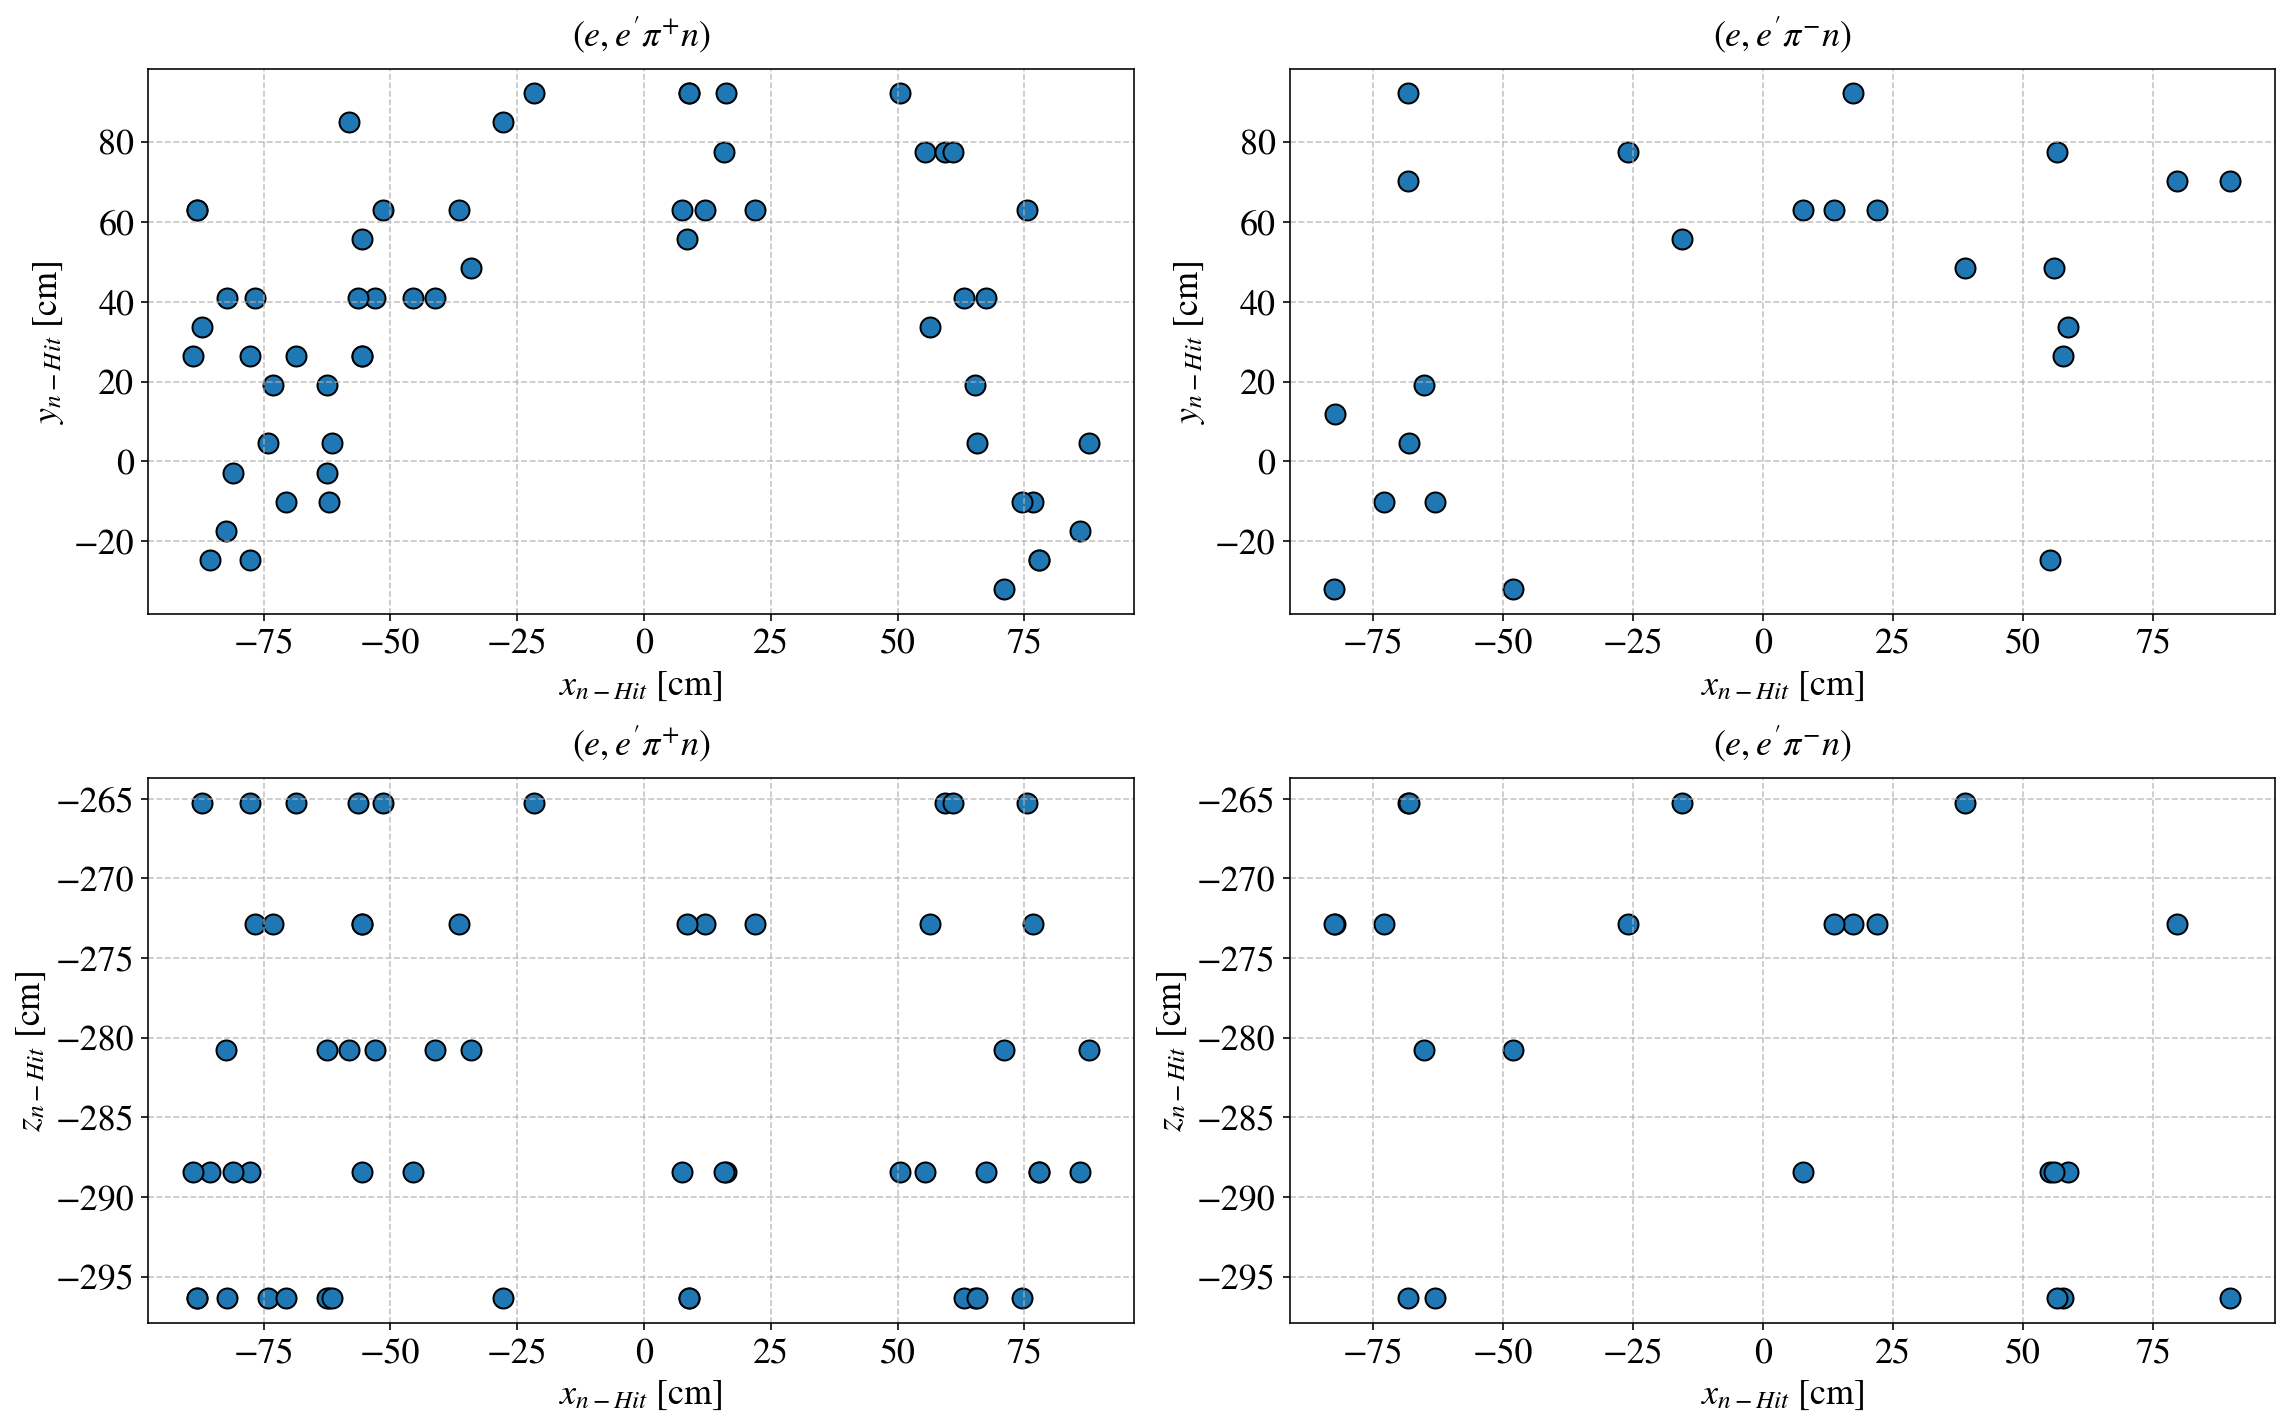

In [34]:
fig = plt.figure(figsize=(16,10),tight_layout=True)
for pi_ch,pi_print,pi_label,pi_color,pi_idx in zip(pi_charge_names,pi_prints,pi_labels,pi_colors,[1,2]):
    ax = fig.add_subplot(2,2,pi_idx)

    df = e_e_pi_n_pass_cuts[pi_ch]
    # scatter_plot_with_kernel(x=df.n_HitPos_X , y = df.n_HitPos_Y, s=100,do_add_colorbar=False,cmap='jet')
    plt.scatter(x=df.n_HitPos_X , y = df.n_HitPos_Y, s=100,cmap='jet', edgecolor='k')    
    set_axes(ax,
             "$x_{n-Hit}$ [cm]", 
             "$y_{n-Hit}$ [cm]", 
             title="$(e,e'"+pi_label+" n)$",
             do_add_grid=True, do_add_legend=False,fontsize=18)    
    
    ax = fig.add_subplot(2,2,2+pi_idx)
    plt.scatter(x=df.n_HitPos_X , y = df.n_HitPos_Z, s=100,cmap='jet', edgecolor='k')        
    set_axes(ax,
             "$x_{n-Hit}$ [cm]", 
             "$z_{n-Hit}$ [cm]", 
             title="$(e,e'"+pi_label+" n)$",
             do_add_grid=True, do_add_legend=False,fontsize=18)

# arxiv

## (3.2) now choose binning and plot $p_n$ distribution in each bin 

In [ ]:
x_bins   = np.linspace(0.2,0.5,6)
x        = (x_bins[1:] + x_bins[:-1])/2
x_err    = (x_bins[1:] - x_bins[:-1])/2
Nbins    = len(x_bins)
x_bins

In [ ]:
var_label = "standing proton x"
var    = 'xB'
xlabel = "Bjorken $x$"

In [ ]:
fig = plt.figure(figsize=(12,8))
pi_ch = 'piplus'
for bin_idx in range(Nbins):
    x_min, x_max  = x_bins[bin_idx] - x_err[1], x_bins[bin_idx] + x_err[1]
    # df = e_e_pi_pass_cuts[pi_ch];
    # eepi_in_bin   = df[ (x_min < df.xB ) & (df.xB < x_max )]

    df = e_e_pi_n_pass_cuts[pi_ch];
    eepi_n_in_bin = df[ (x_min < df.xB ) & (df.xB < x_max )]

    ax  = fig.add_subplot(2,Nbins/2,bin_idx+1)
    ax.hist( eepi_n_in_bin.n_P, bins=np.linspace(0.2,0.6,20) )
    set_axes(ax,'$p_n$ [GeV]','counts', title='$%.2f < x_B < %.2f$'%(x_min,x_max), xlim=(0.2,0.6),fontsize=16);

plt.tight_layout()

# Add two lines indicating the cut boundaries
# estimate background from distribution outside the cut region

## Other kinematical variables like $Q^2$ and $W$

In [ ]:
np.min(df.xB)

In [ ]:
var  = 'W'
bins = np.linspace(1.5,4,21)
varlabel = '$W^2$'
varunits = '[GeV/c$^2$]'

fig = plt.figure(figsize=(14,6))

for pi_ch,pi_print,pi_label,pi_color,pi_idx in zip(pi_charge_names,pi_prints,pi_labels,pi_colors,[1,2]):
    ax = fig.add_subplot(1,2,pi_idx)
    
    df = e_e_pi_pass_cuts[pi_ch]
    x,h,_,_ = plot_step_hist( df[var], bins=bins, marker='o', 
                             linewidth=0.5, color=pi_color,label=None, alpha=1, density=True)
    ax.step(x,h,'-k',where='mid',label='untagged', )

    df = e_e_pi_n_pass_cuts[pi_ch]
    plot_step_hist( df[var], bins=bins, marker='s', markersize=10, color=pi_color,label='tagged', alpha=1, density=True)

    set_axes(ax,varlabel+varunits,'Frequency [a.u.]', 
             title="$(e,e'"+pi_label+")$ events as a function of "+varlabel,
             do_add_grid=True, do_add_legend=True)
plt.tight_layout()

###

In [ ]:
main_data_path = '/Users/erezcohen/Desktop/data/BAND/'
results_data_path = main_data_path + '/' + 'Results' + '/'
for z_bin,z_width in zip(z_bins,z_widths):
    y    = Rpips2pims[z_bin]
    y_err_up = Rpips2pims_errup[z_bin]
    y_err_dw = Rpips2pims_errdw[z_bin]
    df_to_save = pd.DataFrame({"$x_B$":x,"$\Delta x_B$":x_err,
                               '$R$':y,
                               '$\Delta R_{+}$':y_err_up,'$\Delta R_{-}$':y_err_dw})
    print('$z=%.2f\pm%.2f$'%(z_bin,z_width))
    filelabel = 'z_%.2f-%.2f'%(z_bin-z_width,z_bin+z_width)
    filename  =  results_data_path + 'Untagged_SIDIS_ratio_' + filelabel + '.csv'
    print(filename)
    
    display(df_to_save)
    # df_to_save.to_csv(filename)
    # print('saved',filename)